# Task 1

Here is the link for the explaining the task.
https://youtu.be/9Rx7i3e21ks

In [1]:
import os 

# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd

In [2]:
import time
import os 
import numpy as np
import scipy.stats

import sklearn
import sklearn.datasets

import pandas as pd
from datetime import datetime

%matplotlib notebook  
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan, when, count
import pyspark.sql.functions as f
from pyspark.sql.functions import * 

In [3]:
#This is needed to start a Spark session from the notebook
os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=70g  pyspark-shell"

from pyspark.sql import SparkSession

In [4]:
#Solution
spark = SparkSession \
    .builder \
    .master("local[2]") \
    .appName("task_feature") \
    .getOrCreate()

22/06/03 20:49:38 WARN Utils: Your hostname, Fatemehs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.178.38 instead (on interface en0)
22/06/03 20:49:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/03 20:49:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Import the data

In [5]:
feature_engineered = spark.read.load('feature_engineered.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

In [6]:
#Load the ./data/churn-bigml-80.csv and store in CV_data
train_sessions = spark.read.load('./data/train_sessions.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

In [7]:
train_purchases = spark.read.load('./data/train_purchases.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

In [8]:
item_features = spark.read.load('./data/item_features.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

In [9]:
candidate_items = spark.read.load('./data/candidate_items.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

In [10]:
test_final_sessions = spark.read.load('./data/test_final_sessions.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

In [11]:
test_leaderboard_sessions = spark.read.load('./data/test_leaderboard_sessions.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

In [12]:
train_sessions.show()

+----------+-------+--------------------+
|session_id|item_id|                date|
+----------+-------+--------------------+
|         3|   9655|2020-12-18 21:25:...|
|         3|   9655|2020-12-18 21:19:...|
|        13|  15654|2020-03-13 19:35:...|
|        18|  18316|2020-08-26 19:18:...|
|        18|   2507|2020-08-26 19:16:...|
|        18|   4026|2020-08-26 19:15:...|
|        19|  25772|2020-11-02 16:31:...|
|        19|   6341|2020-11-02 16:34:...|
|        19|  25555|2020-11-02 16:43:...|
|        19|  20033|2020-11-02 16:42:...|
|        19|   8281|2020-11-02 16:38:...|
|        19|   8268|2020-11-02 16:48:...|
|        19|   4385|2020-11-02 16:44:...|
|        19|   6704|2020-11-02 16:47:...|
|        19|   8316|2020-11-02 16:36:...|
|        19|  27638|2020-11-02 16:41:...|
|        19|   8813|2020-11-02 16:39:...|
|        19|  19896|2020-11-02 16:30:...|
|        19|  27937|2020-11-02 16:30:...|
|        19|  23687|2020-11-02 16:35:...|
+----------+-------+--------------

In [13]:
train_sessions.printSchema()

root
 |-- session_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- date: string (nullable = true)



In [14]:
train_purchases.show()

+----------+-------+--------------------+
|session_id|item_id|                date|
+----------+-------+--------------------+
|         3|  15085|2020-12-18 21:26:...|
|        13|  18626|2020-03-13 19:36:...|
|        18|  24911|2020-08-26 19:20:...|
|        19|  12534|2020-11-02 17:16:...|
|        24|  13226|2020-02-26 18:27:...|
|        28|  26394|2020-05-18 12:52:...|
|        31|   8345|2021-04-20 19:46:...|
|        36|  14532|2020-06-21 10:33:...|
|        42|  11784|2021-03-01 15:17:...|
|        44|   4028|2020-11-27 20:46:...|
|        48|  24022|2020-04-15 17:29:...|
|        49|   2011|2020-05-01 12:34:...|
|        52|  12556|2020-03-21 11:49:...|
|        75|  28057|2020-05-24 17:27:...|
|        77|   4243|2020-09-20 21:37:...|
|       107|   4016|2020-01-15 06:07:...|
|       108|  18532|2020-06-06 17:25:...|
|       113|  21107|2021-05-05 14:15:...|
|       115|  25976|2021-05-27 10:24:...|
|       119|    434|2020-10-11 06:32:...|
+----------+-------+--------------

In [15]:
train_purchases.printSchema()

root
 |-- session_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- date: string (nullable = true)



In [16]:
item_features.show()

+-------+-------------------+----------------+
|item_id|feature_category_id|feature_value_id|
+-------+-------------------+----------------+
|      2|                 56|             365|
|      2|                 62|             801|
|      2|                 68|             351|
|      2|                 33|             802|
|      2|                 72|              75|
|      2|                 29|             123|
|      2|                 16|              38|
|      2|                 50|              76|
|      2|                 61|             462|
|      2|                 53|               6|
|      2|                  7|             394|
|      2|                 69|             885|
|      2|                 47|             123|
|      3|                 56|             365|
|      3|                 69|             592|
|      3|                 68|              14|
|      3|                 17|             378|
|      3|                 32|             902|
|      3|    

In [17]:
item_features.printSchema()

root
 |-- item_id: integer (nullable = true)
 |-- feature_category_id: integer (nullable = true)
 |-- feature_value_id: integer (nullable = true)



# checking for null values

We check if there are any null values in the datasets. It showes that there not any null values.

In [18]:
from pyspark.sql.functions import col,isnan, when, count
train_sessions.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_sessions.columns]
   ).show()

+----------+-------+----+
|session_id|item_id|date|
+----------+-------+----+
|         0|      0|   0|
+----------+-------+----+



In [19]:
train_purchases.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_purchases.columns]
   ).show()

+----------+-------+----+
|session_id|item_id|date|
+----------+-------+----+
|         0|      0|   0|
+----------+-------+----+



In [20]:
item_features.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in item_features.columns]
   ).show()

+-------+-------------------+----------------+
|item_id|feature_category_id|feature_value_id|
+-------+-------------------+----------------+
|      0|                  0|               0|
+-------+-------------------+----------------+



# feature engineering

In this part we add features based on the data that we have. we can use the date and item_id.

1. number of items in each session

In [21]:
import pyspark.sql.functions as f

df_1 = train_sessions.groupBy('session_id').count().select('session_id', f.col('count').alias('item_count'))
#df_1.sort("session_id").show()

2. number of distinct items in each session

In [22]:
from pyspark.sql.functions import * 

df_2 = train_sessions.groupby("session_id").agg(countDistinct("item_id")).select('session_id', f.col('count(item_id)').alias("num_distinct_item"))

df_2.sort("session_id").show()

+----------+-----------------+
|session_id|num_distinct_item|
+----------+-----------------+
|         3|                1|
|        13|                1|
|        18|                3|
|        19|               17|
|        24|                8|
|        28|                3|
|        31|                7|
|        36|                2|
|        42|                4|
|        44|                2|
|        48|                2|
|        49|                1|
|        52|                2|
|        75|                1|
|        77|                4|
|       107|                3|
|       108|               24|
|       113|                6|
|       115|                4|
|       119|                3|
+----------+-----------------+
only showing top 20 rows



3. first item in the session

In [23]:
#convert date from string to timestamp
df_time = train_sessions.withColumn("time", to_timestamp(train_sessions.date, 'yyyy-MM-dd HH:mm:ss.SSSS'))

In [24]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number
w2 = Window.partitionBy("session_id").orderBy(col("time"))
df_3 = df_time.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row") 
df_3 = df_3.withColumnRenamed("item_id","first_item")
#df_3.sort('session_id').show()  

4. last item in the session

In [25]:
w2 = Window.partitionBy("session_id").orderBy(col("time").desc())
df_4 = df_time.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row") 
df_4 = df_4.withColumnRenamed("item_id","last_item")
#df_4.sort('session_id').show()  

5. year of session

In [26]:
df_sessions = df_4.toPandas()

In [27]:
def convert(fa):
    try:
        return datetime.strptime(fa, '%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
        return datetime.strptime(fa, '%Y-%m-%d %H:%M:%S')   

df_sessions["date"] = df_sessions['date'].apply(lambda x: convert(x))

In [28]:
df_sessions['year'] = df_sessions['date'].dt.year

6.month of session

In [29]:
df_sessions['month'] = df_sessions['date'].dt.month

7.day 

In [30]:
df_sessions['day'] = df_sessions['date'].dt.day

8.week 

In [31]:
df_sessions['week'] = df_sessions['date'].dt.week

9. day of year

In [32]:
df_sessions['dayofyear'] = df_sessions['date'].dt.dayofyear

10. season of session

In [33]:
df_sessions['quarter'] = df_sessions['date'].dt.quarter

11. day of week

In [34]:
df_sessions['dayofweek'] = df_sessions['date'].dt.dayofweek

12. Hour

In [35]:
df_sessions['hour'] = df_sessions['date'].dt.hour

In [36]:
df_sessions['minute'] = df_sessions['date'].dt.minute

13. seconds

In [37]:
df_sessions['second'] = df_sessions['date'].dt.second

In [38]:
df_sessions['seconds'] = df_sessions['second'] + (60 * df_sessions['minute']) + (3600 * df_sessions['hour'])

In [39]:
df_s = df_sessions[['session_id','seconds']]

In [40]:
df_12 = spark.createDataFrame(df_s)

13. morning

In [41]:
#morning is between 5am to 12pm
df_13 = df_12.withColumn('morning', f.when(((f.col('seconds') < 43199) & (f.col('seconds') > 18000)), 1).otherwise(0))

14. afternoon

In [42]:
#afternon is between 12pm to 5pm
df_14 = df_12.withColumn('aftrenoon', f.when(((f.col('seconds') <= 61200) & (f.col('seconds') >= 43200)), 1).otherwise(0))

15. evening

In [43]:
#evening is between 5pm to 9pm
df_15 = df_12.withColumn('evening', f.when(((f.col('seconds') <= 75600) & (f.col('seconds') > 61200)), 1).otherwise(0))

16. night

In [44]:
#night is between 9pm to 4am
df_16 = df_12.withColumn('night', f.when(((f.col('seconds') <= 18000) & (f.col('seconds') > 75600)), 1).otherwise(0))

17. duration of session

In [45]:
df_train = pd.read_csv('./data/train_sessions.csv') 

In [46]:
def convert(fa):
    try:
        return datetime.strptime(fa, '%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
        return datetime.strptime(fa, '%Y-%m-%d %H:%M:%S')   

df_train["date"] = df_train['date'].apply(lambda x: convert(x))

In [47]:
df_train['hour'] = df_train['date'].dt.hour
df_train['minute'] = df_train['date'].dt.minute
df_train['second'] = df_train['date'].dt.second
df_train['seconds'] = df_train['second'] + (60 * df_train['minute']) + (3600 * df_train['hour'])

In [48]:
a = df_train.groupby('session_id')['seconds'].agg(['max','min']).reset_index()
df_sessions['duration'] = a['max']- a['min']

18. weekday 

In [49]:
df_sessions.loc[df_sessions['dayofweek'] > 5, 'weekend'] = 1
df_sessions.loc[df_sessions['dayofweek'] < 6, 'weekday'] = 1
df_sessions['weekend'] = df_sessions['weekend'].fillna(0)
df_sessions['weekday'] = df_sessions['weekday'].fillna(0)

19. weekend

In [50]:
#df_sessions.head()

In [51]:
df_sessions = df_sessions.drop(columns=['last_item','date','time'])

In [52]:
df_comp = spark.createDataFrame(df_sessions)

20. maximun number of repeated item

In [53]:
df_20_1 = train_sessions.groupBy('session_id', 'item_id').agg(f.count('*').alias('count_item')).orderBy('session_id')
#df_20.show()

In [54]:
df_20 = df_20_1.groupBy('session_id').agg(f.max('count_item').alias('max_item_count'))

21. most visited item for each session

In [55]:
w2 = Window.partitionBy("session_id").orderBy(col("count_item"))
df_21 = df_20_1.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row") 
df_21 = df_21.withColumnRenamed("item_id","most_viewed_item")
#df_21.sort('session_id').show()  

Start working with the item_features dataset

In [56]:
#merge the train_session and item_features based on Item_id to get the category_id and value_id for each session

In [57]:
features = item_features.withColumnRenamed("item_id","item_id_2")
df_merg = train_sessions.join(features, train_sessions.item_id ==  features.item_id_2,"inner") 
df_merg = df_merg.drop("item_id_2","date")
#item_features.show()

In [117]:
#df_merg.show()

+----------+-------+-------------------+----------------+
|session_id|item_id|feature_category_id|feature_value_id|
+----------+-------+-------------------+----------------+
|         3|   9655|                 47|             512|
|         3|   9655|                 42|             409|
|         3|   9655|                 23|             510|
|         3|   9655|                 39|             731|
|         3|   9655|                 68|             393|
|         3|   9655|                 67|             349|
|         3|   9655|                 38|             138|
|         3|   9655|                 37|              45|
|         3|   9655|                 51|             597|
|         3|   9655|                 50|             240|
|         3|   9655|                 55|             267|
|         3|   9655|                 73|             544|
|         3|   9655|                  2|              53|
|         3|   9655|                 31|             768|
|         3|  

In [58]:
df_1 = train_sessions.groupby("session_id").agg(countDistinct("item_id")).select('session_id', f.col('count(item_id)').alias("num_distinct_item"))

22. number of categories for each session

In [59]:
df_22 = df_merg.groupby("session_id").agg(countDistinct("feature_category_id")).alias("num_distinct_category")
df_22 = df_22.withColumnRenamed("count(feature_category_id)","num_distinct_category")

In [121]:
#df_23.show()

+----------+---------------------+
|session_id|num_distinct_category|
+----------+---------------------+
|      1829|                   35|
|     15790|                   29|
|     21220|                   26|
|     24171|                   31|
|     33868|                   25|
|     37111|                   25|
|     41890|                   25|
|     42635|                   20|
|     53191|                   19|
|     56640|                   25|
|     73470|                   18|
|     79220|                   34|
|     81501|                   26|
|     82582|                   36|
|     83861|                   41|
|     97419|                   51|
|    100446|                   19|
|    102793|                   33|
|    107536|                   19|
|    108806|                   19|
+----------+---------------------+
only showing top 20 rows



23. number of distinct category for each session

In [60]:
df_23 = df_merg.groupby("session_id").agg(count("feature_category_id")).alias("num_category")
df_23 = df_23.withColumnRenamed("count(feature_category_id)","num_category")

In [151]:
#df_23.show()

+----------+------------+
|session_id|num_category|
+----------+------------+
|       496|         126|
|      1829|         100|
|      3175|          96|
|      3794|          24|
|      5156|          63|
|      6357|         198|
|      7880|          24|
|      8086|          20|
|      8638|          77|
|      9376|          98|
|      9427|          18|
|      9900|          18|
|     10623|          24|
|     11141|          59|
|     11317|         183|
|     13285|          69|
|     13623|          85|
|     15447|          40|
|     15619|         166|
|     15790|          41|
+----------+------------+
only showing top 20 rows



we pair the category_id and value_id

In [61]:
df_24 = df_merg.groupby("session_id")

In [62]:
df_25 = item_features.select(concat_ws('_',df_merg.feature_category_id,df_merg.feature_value_id).alias("category_value"),"item_id")

In [63]:
df_25 = df_25.withColumn('count', lit(1))

In [169]:
#df_25.show()

+--------------+-------+-----+
|category_value|item_id|count|
+--------------+-------+-----+
|        56_365|      2|    1|
|        62_801|      2|    1|
|        68_351|      2|    1|
|        33_802|      2|    1|
|         72_75|      2|    1|
|        29_123|      2|    1|
|         16_38|      2|    1|
|         50_76|      2|    1|
|        61_462|      2|    1|
|          53_6|      2|    1|
|         7_394|      2|    1|
|        69_885|      2|    1|
|        47_123|      2|    1|
|        56_365|      3|    1|
|        69_592|      3|    1|
|         68_14|      3|    1|
|        17_378|      3|    1|
|        32_902|      3|    1|
|        11_859|      3|    1|
|        45_559|      3|    1|
+--------------+-------+-----+
only showing top 20 rows



In [64]:
pivotDF = df_25.groupBy("item_id").pivot("category_value").sum("count")

In [65]:
pivotDF = pivotDF.na.fill(value=0)

In [66]:
pivot = pivotDF.toPandas()

22/06/03 21:05:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [67]:
pivot = pivot.sort_values("item_id")

In [60]:
pivot.to_csv('pivot.csv', index=False)

In [68]:
pivot_1 = pivot.drop(columns =["item_id"])

In [70]:
pivot_1.head(10)

,10_147,10_159,10_184,10_217,10_22,10_287,10_361,10_407,10_464,10_561,...,7_837,7_838,8_157,8_323,8_420,8_636,9_175,9_178,9_190,9_369
20703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12190,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
12775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In this part we use PCA to decrease the dimension.

In [71]:
X = pivot_1.to_numpy()

In [72]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import cluster

Elbow method

In [73]:
x = pivot_1.iloc[:,2:]
print(x)

       10_184  10_217  10_22  10_287  10_361  10_407  10_464  10_561  10_631  \
20703       0       0      0       0       0       0       0       0       0   
6085        0       0      0       0       0       0       0       0       0   
12190       0       0      0       0       0       0       0       0       0   
12775       0       0      0       0       0       0       0       0       0   
12374       0       0      0       0       0       0       0       0       0   
...       ...     ...    ...     ...     ...     ...     ...     ...     ...   
15293       0       0      0       0       0       0       0       0       0   
3839        0       0      0       0       0       0       0       0       0   
8426        0       0      0       0       0       0       0       0       0   
14705       0       0      0       0       0       0       0       0       0   
15512       0       0      0       0       0       0       0       0       0   

       10_644  ...  7_837  7_838  8_157

In [74]:
x.shape

(23691, 902)

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = []
for i in range(1,20):
    model = KMeans(n_clusters = i, init = "k-means++")
    model.fit(x)
    wcss.append(model.inertia_)

<IPython.core.display.Javascript object>


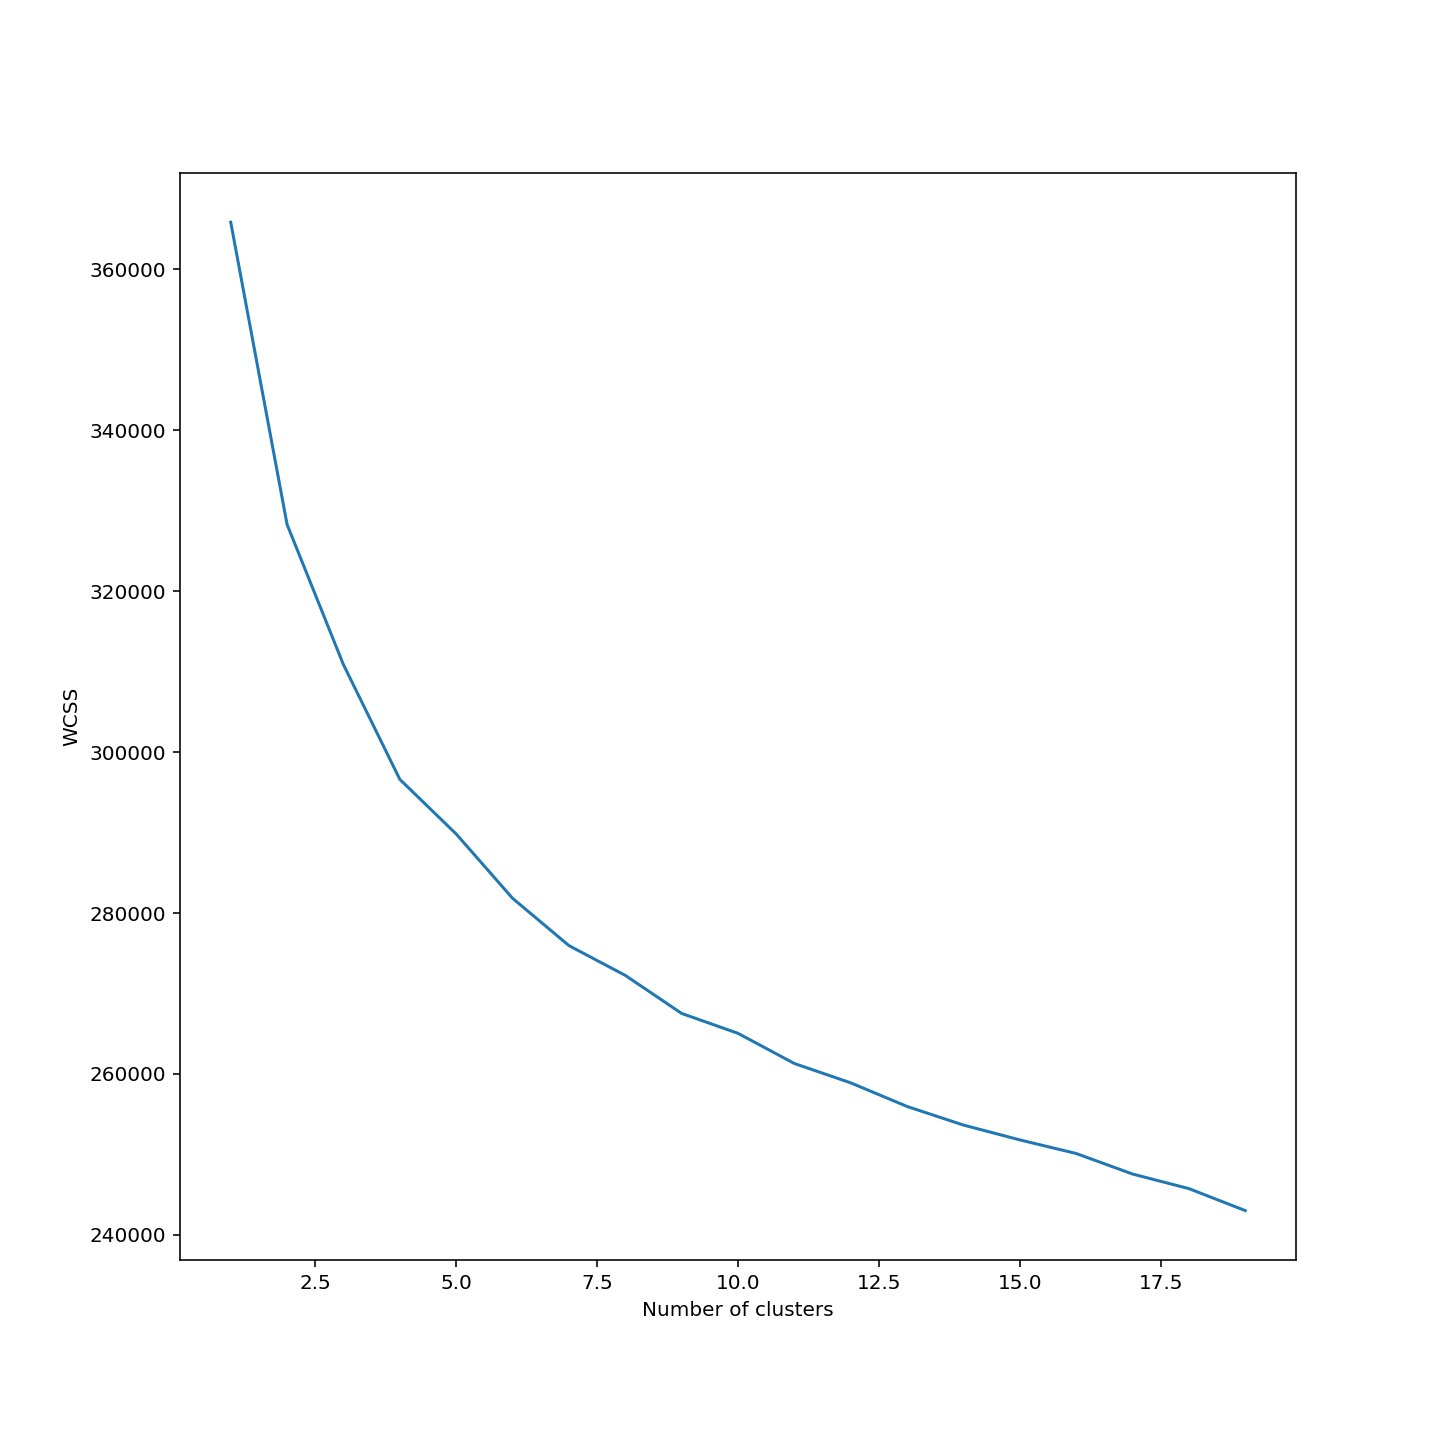

In [76]:
plt.figure(figsize=(10,10))
plt.plot(range(1,20), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# PCA

In [77]:
pca = PCA(2)
pca.fit(X)
feature_pca = pca.transform(X)

In [78]:
feature_pca[10]

array([1.89849574, 0.22474723])

<IPython.core.display.Javascript object>


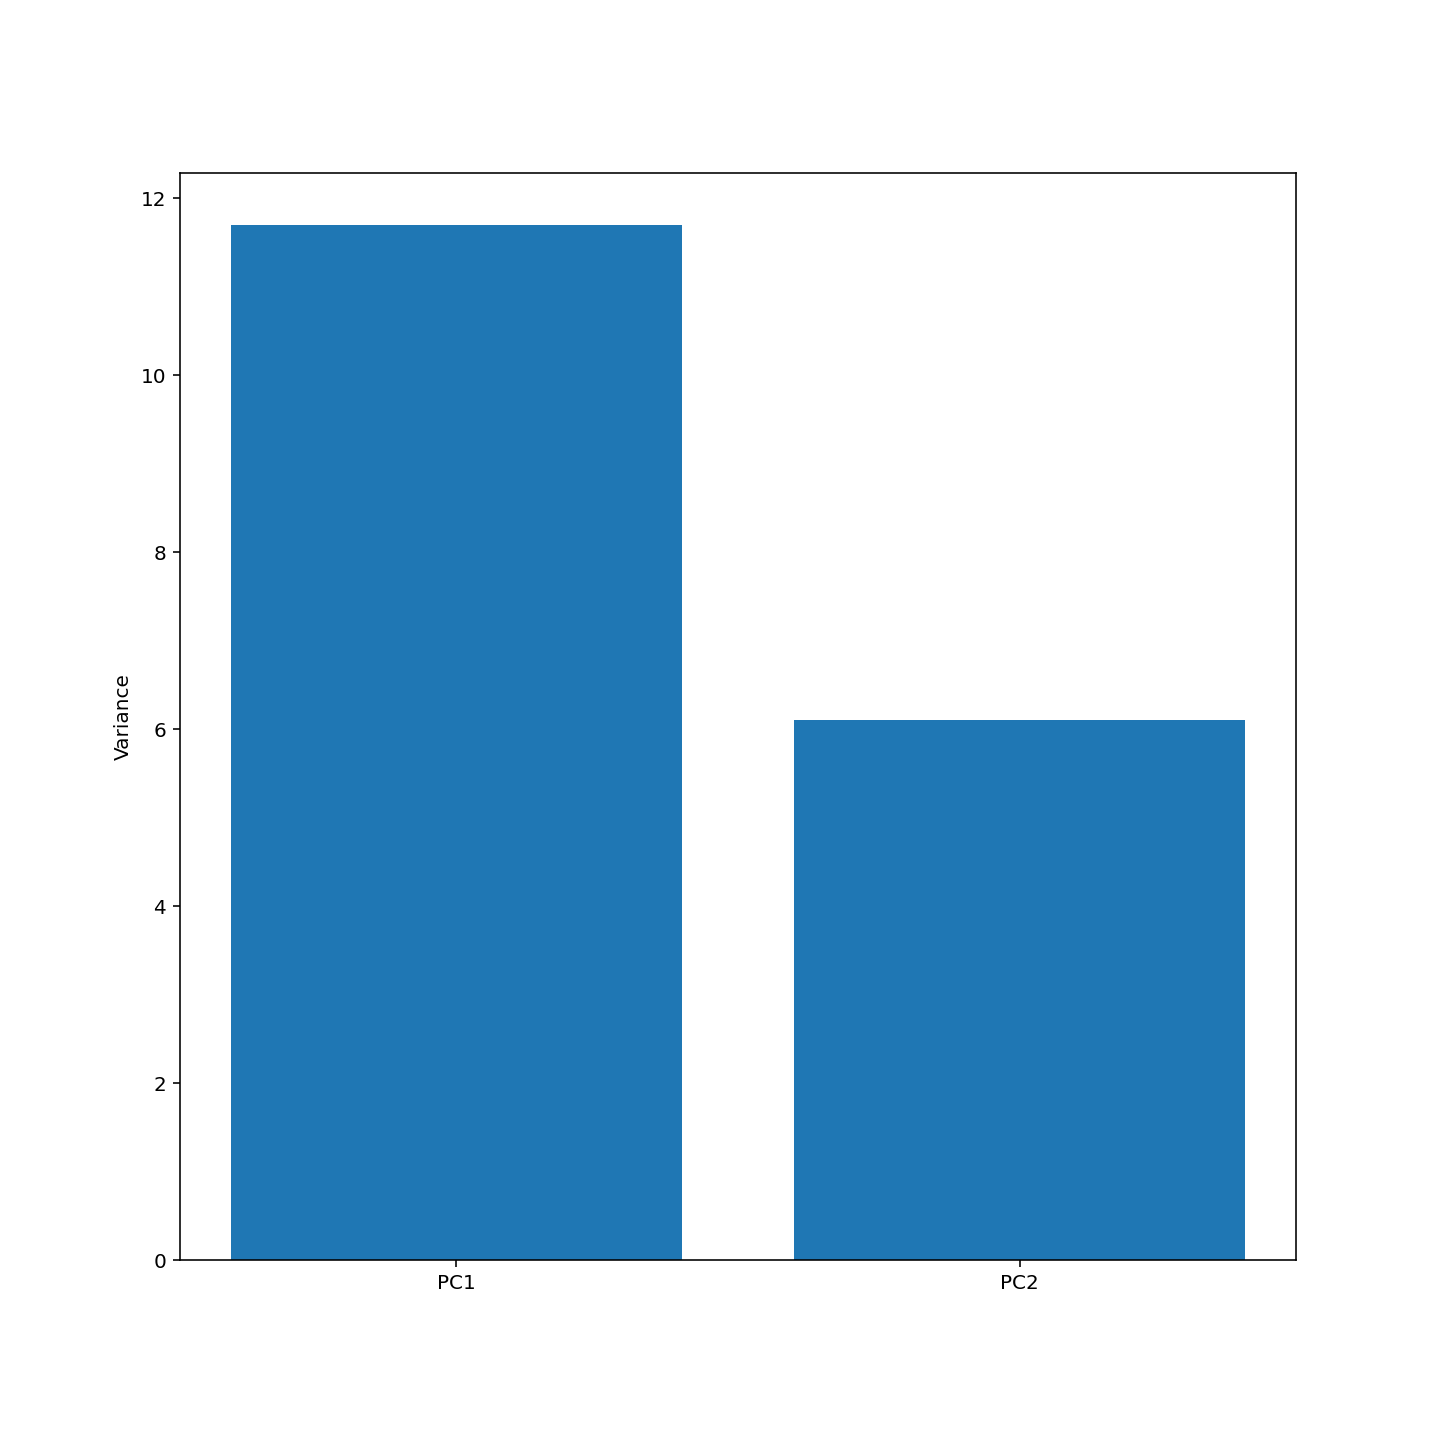

In [79]:
plt.figure(figsize=(10,10))
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
lbls = ['PC'+ str(x) for x in range(1,len(var)+1)]
plt.bar(x=range(1,len(var)+1), height = var, tick_label = lbls)
plt.ylabel('Variance')
plt.show()

# Clustring

In this part we use kmeans clustring to cluster our data.

In [81]:
model2 = KMeans(n_clusters = 20, init = "k-means++")
label2 = model2.fit_predict(feature_pca)

<IPython.core.display.Javascript object>


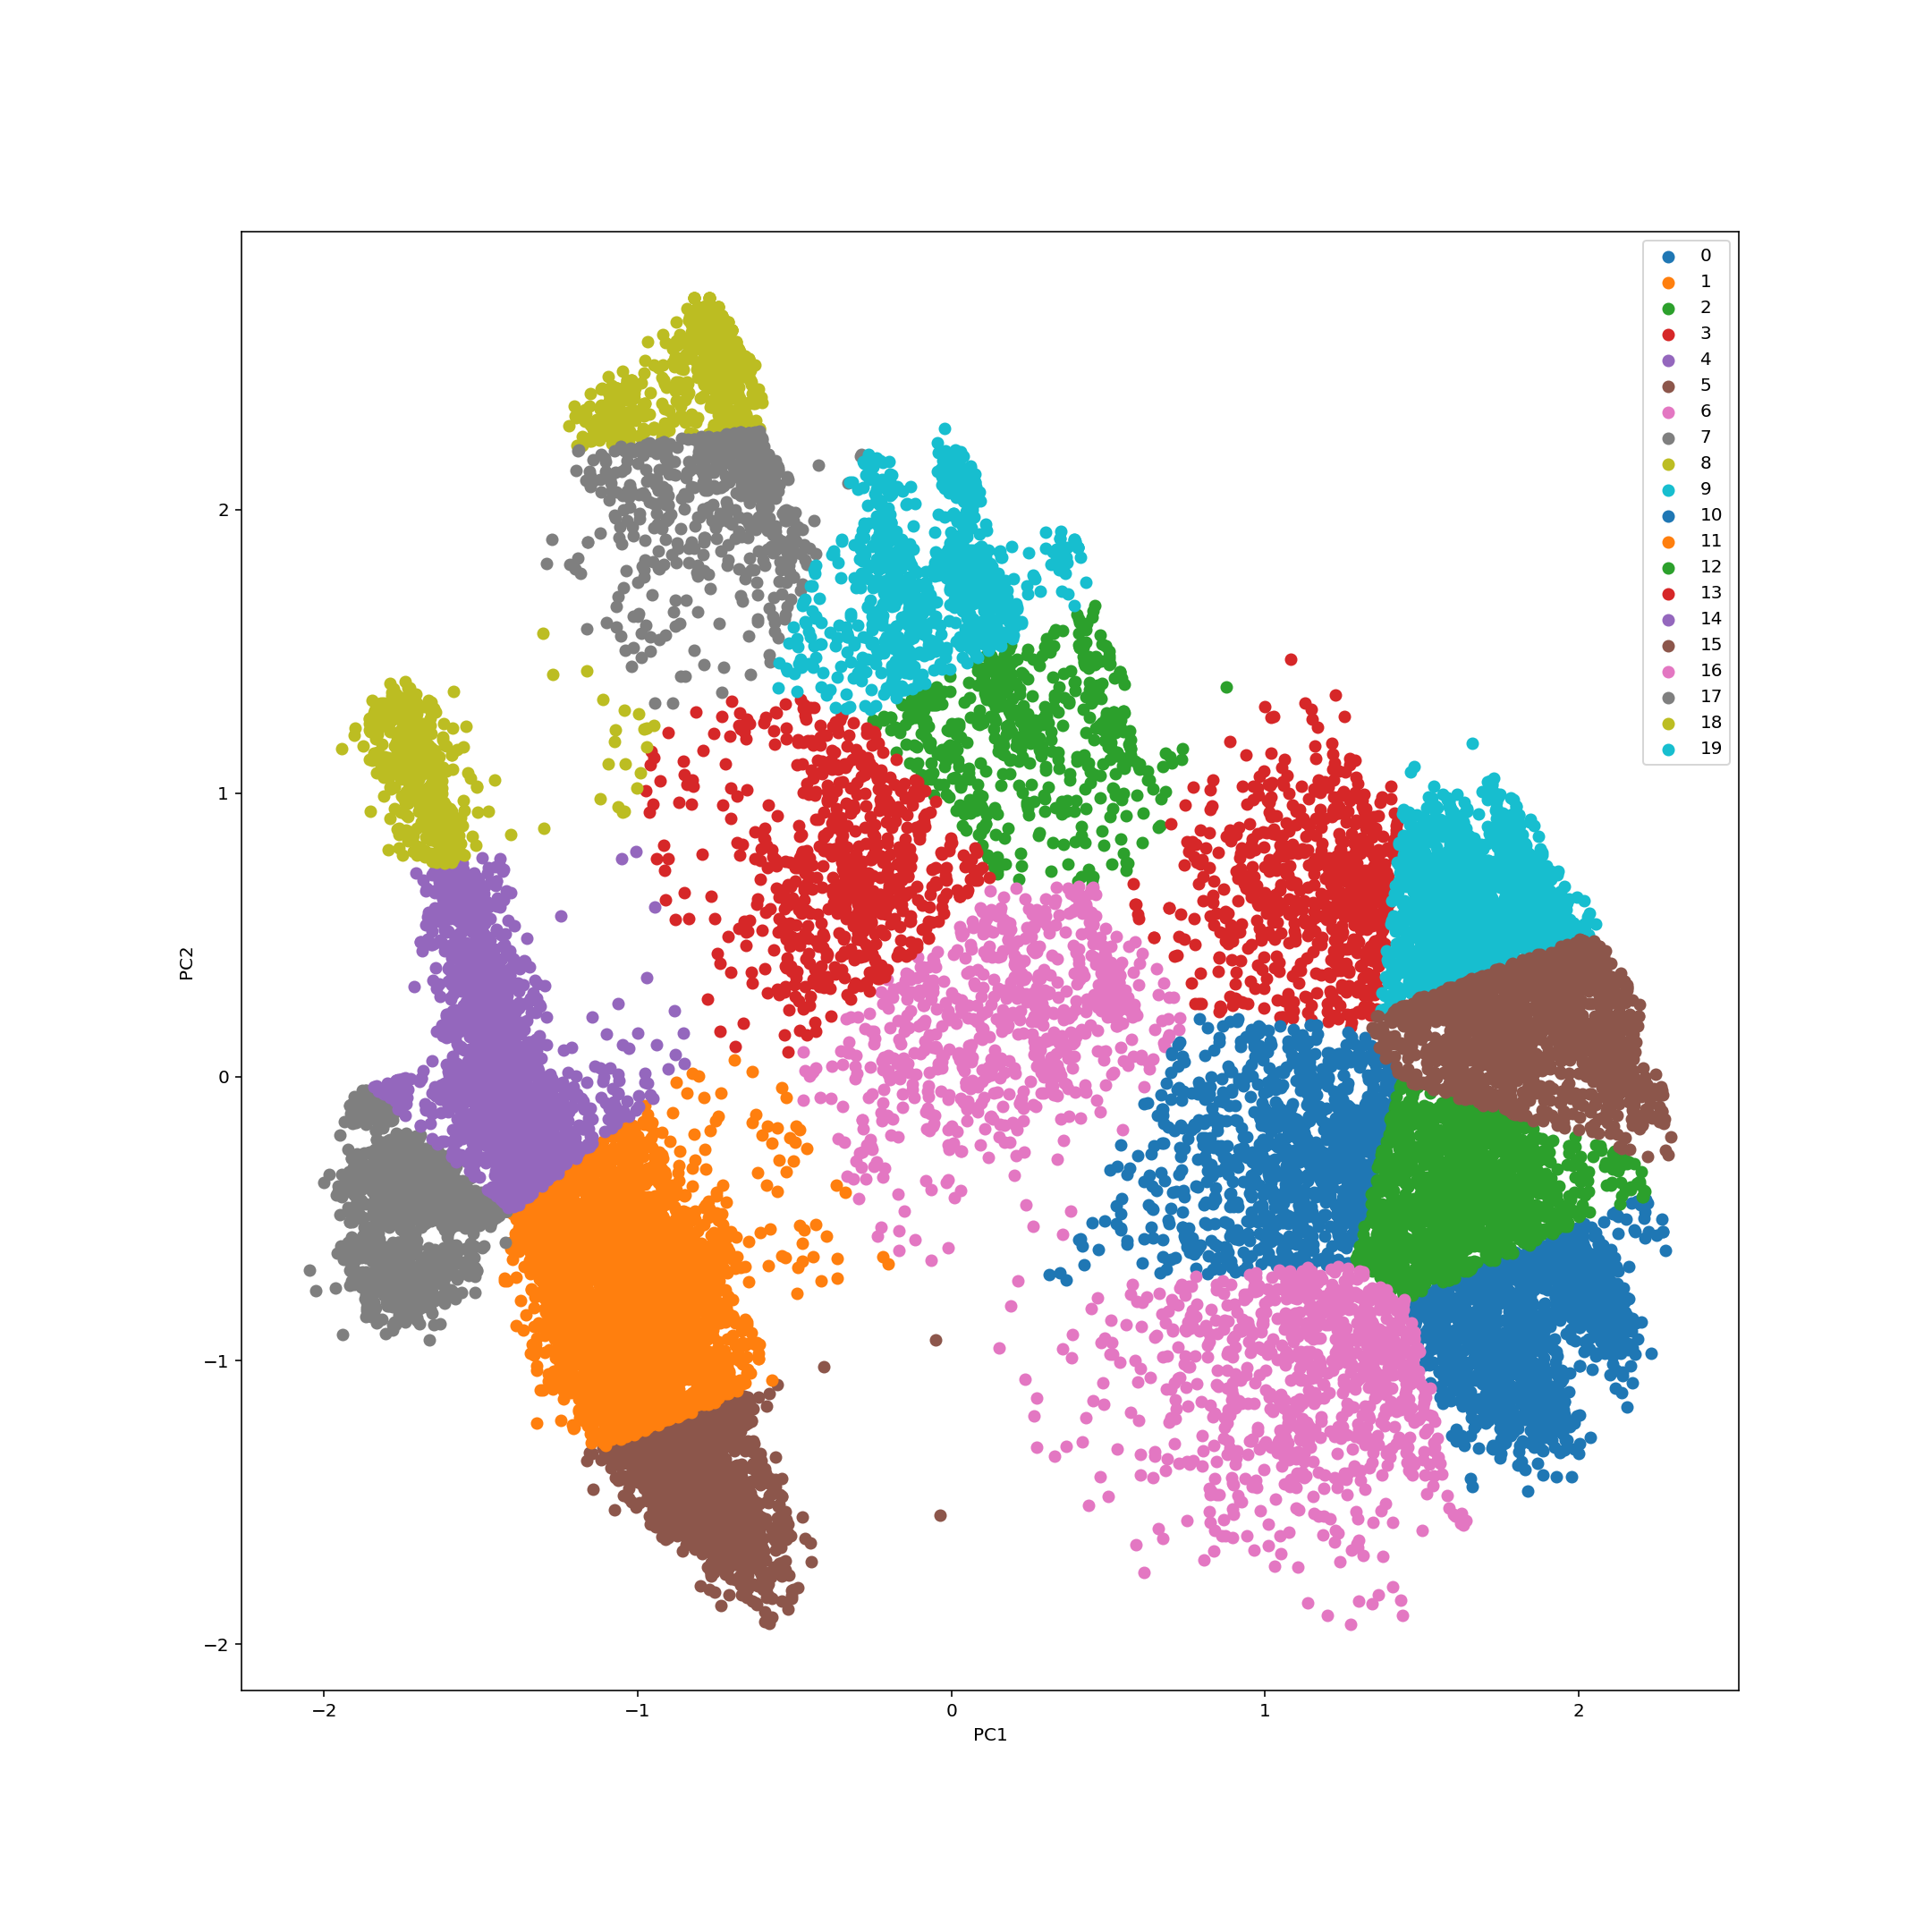

In [82]:
plt.figure(figsize=(15,15))
uniq = np.unique(label2)
for i in uniq:
    plt.scatter(feature_pca[label2 == i , 0] , feature_pca[label2 == i , 1] , label = i)
plt.xlabel([])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [83]:
clusters = model2.labels_

In [84]:
clusters.shape

(23691,)

In [85]:
df_cluster = pd.DataFrame(clusters, columns=['cluster'])

In [86]:
df_cluster.to_csv('cluster.csv', index=False)

In [87]:
#df_cluster.head()

In [42]:
df_features = pd.read_csv('./data/item_features.csv')

In [89]:
#df_features.shape

In [ ]:
#concat item_features with cluster


In [ ]:
# we add the sessions and items to the clusters

In [41]:
spark_cluste = spark.createDataFrame(df_cluster) 

In [90]:
group_item = item_features.groupBy('item_id')

In [92]:
#join sessions and items with clusters
df_features = pd.read_csv('./data/item_features.csv') 

In [93]:
df_features = df_features.sort_values('item_id')
df_features = df_features.drop(columns=['feature_category_id','feature_value_id'])

In [94]:
df_features = df_features.groupby('item_id').count().reset_index()

In [95]:
#df_features.head()

In [96]:
#concat item_id with cluster
result = pd.concat([df_features, df_cluster], axis=1)

In [97]:
#result.head()

In [98]:
result['count'] = 1

In [99]:
#result.head()

In [54]:
result.to_csv('clusters.csv', index=False)

In [100]:
spark_cluster = spark.createDataFrame(result)

In [102]:
spark_cluster = spark_cluster.withColumnRenamed("item_id","item_id_2")
new = train_sessions.join(spark_cluster, train_sessions.item_id ==  spark_cluster.item_id_2,"inner") 
new = new.drop("item_id_2")

In [103]:
new = new.drop('date','item_id')

In [104]:
new.show()

+----------+-------+-----+
|session_id|cluster|count|
+----------+-------+-----+
|        24|      6|    1|
|        24|      6|    1|
|        75|      0|    1|
|       108|      5|    1|
|       900|      7|    1|
|      1259|      9|    1|
|      1563|      8|    1|
|      1957|     13|    1|
|      2489|      4|    1|
|      2950|      0|    1|
|      3102|      8|    1|
|      3787|     10|    1|
|      4163|      8|    1|
|      4239|     19|    1|
|      4270|     10|    1|
|      4285|     19|    1|
|      4450|      3|    1|
|      4450|      3|    1|
|      4911|     19|    1|
|      5258|     11|    1|
+----------+-------+-----+
only showing top 20 rows



In [105]:
final = new.groupBy("session_id").pivot("cluster").sum("count")

In [106]:
final = final.na.fill(value=0)

In [107]:
final.show(2)

+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|session_id|  0|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12| 13| 14| 15| 16| 17| 18| 19|
+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|   1770020|  0|  0|  0|  0|  0|  0|  0|  0|  9|  0|  0|  0|  0|  0|  0|  0|  0|  2|  0|  0|
|   2018449|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  2|  0|  0|
+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
only showing top 2 rows



In [67]:
final.toPandas().to_csv('final.csv', index=False)

In [20]:
item_cluster = spark.read.load('clusters.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

In [22]:
#find the cluster for each item in the train_purchase
train_purchases = train_purchases.withColumnRenamed("item_id","item_id_2")
purchase_cluster = item_cluster.join(train_purchases, item_cluster.item_id ==  train_purchases.item_id_2,"inner") 
purchase_cluster = purchase_cluster.drop("item_id_2")


In [24]:
purchase_cluster.show()

+-------+-------+-----+------------+--------------------+
|item_id|cluster|count|session_id_2|                date|
+-------+-------+-----+------------+--------------------+
|  15085|      6|    1|           3|2020-12-18 21:26:...|
|  18626|      1|    1|          13|2020-03-13 19:36:...|
|  24911|     19|    1|          18|2020-08-26 19:20:...|
|  12534|      3|    1|          19|2020-11-02 17:16:...|
|  13226|      7|    1|          24|2020-02-26 18:27:...|
|  26394|     15|    1|          28|2020-05-18 12:52:...|
|   8345|      3|    1|          31|2021-04-20 19:46:...|
|  14532|     12|    1|          36|2020-06-21 10:33:...|
|  11784|      1|    1|          42|2021-03-01 15:17:...|
|   4028|      7|    1|          44|2020-11-27 20:46:...|
|  24022|      1|    1|          48|2020-04-15 17:29:...|
|   2011|     17|    1|          49|2020-05-01 12:34:...|
|  12556|      0|    1|          52|2020-03-21 11:49:...|
|  28057|      9|    1|          75|2020-05-24 17:27:...|
|   4243|     

we join all the dataframe together for the final dataset

In [108]:
df_3 = df_3.drop('date','time')
df_4 = df_4.drop('date','time')
df_13 = df_13.drop('seconds')
df_14 = df_14.drop('seconds')
df_15 = df_15.drop('seconds')
df_16 = df_16.drop('seconds')
df_21 = df_21.drop('count_item')

In [109]:
join_df = df_1.join(df_2,["session_id"]) \
     .join(df_3,["session_id"]) \
     .join(df_4,["session_id"]) \
     .join(df_13,["session_id"]) \
     .join(df_14,["session_id"]) \
     .join(df_15,["session_id"]) \
     .join(df_16,["session_id"]) \
     .join(df_20,["session_id"]) \
     .join(df_21,["session_id"]) \
     .join(df_22,["session_id"]) \
     .join(df_23,["session_id"]) \
     .join(final,["session_id"]) \
     .join(df_comp,["session_id"])

In [112]:
join_df.dtypes

[('session_id', 'int'),
 ('first_item', 'int'),
 ('last_item', 'int'),
 ('morning', 'int'),
 ('aftrenoon', 'int'),
 ('evening', 'int'),
 ('night', 'int'),
 ('max_item_count', 'bigint'),
 ('most_viewed_item', 'int'),
 ('num_distinct_category', 'bigint'),
 ('num_category', 'bigint'),
 ('0', 'bigint'),
 ('1', 'bigint'),
 ('2', 'bigint'),
 ('3', 'bigint'),
 ('4', 'bigint'),
 ('5', 'bigint'),
 ('6', 'bigint'),
 ('7', 'bigint'),
 ('8', 'bigint'),
 ('9', 'bigint'),
 ('10', 'bigint'),
 ('11', 'bigint'),
 ('12', 'bigint'),
 ('13', 'bigint'),
 ('14', 'bigint'),
 ('15', 'bigint'),
 ('16', 'bigint'),
 ('17', 'bigint'),
 ('18', 'bigint'),
 ('19', 'bigint'),
 ('year', 'bigint'),
 ('month', 'bigint'),
 ('day', 'bigint'),
 ('week', 'bigint'),
 ('dayofyear', 'bigint'),
 ('quarter', 'bigint'),
 ('dayofweek', 'bigint'),
 ('hour', 'bigint'),
 ('minute', 'bigint'),
 ('second', 'bigint'),
 ('seconds', 'bigint'),
 ('duration', 'bigint'),
 ('weekend', 'double'),
 ('weekday', 'double')]

In [130]:
#df_comp.show()

22/06/02 08:14:21 WARN TaskSetManager: Stage 52 contains a task of very large size (26001 KiB). The maximum recommended task size is 1000 KiB.


+----------+----+-----+---+----+---------+-------+---------+----+------+------+-------+--------+-------+-------+
|session_id|year|month|day|week|dayofyear|quarter|dayofweek|hour|minute|second|seconds|duration|weekend|weekday|
+----------+----+-----+---+----+---------+-------+---------+----+------+------+-------+--------+-------+-------+
|         3|2020|   12| 18|  51|      353|      4|        4|  21|    25|     0|  77100|     312|    0.0|    1.0|
|        13|2020|    3| 13|  11|       73|      1|        4|  19|    35|    27|  70527|       0|    0.0|    1.0|
|        19|2020|   11|  2|  45|      307|      4|        0|  16|    48|    39|  60519|     163|    0.0|    1.0|
|        28|2020|    5| 18|  21|      139|      2|        0|  12|    51|    51|  46311|    1083|    0.0|    1.0|
|        31|2021|    4| 20|  16|      110|      2|        1|  19|    45|    23|  71123|    3704|    0.0|    1.0|
|        44|2020|   11| 27|  48|      332|      4|        4|  20|    45|    43|  74743|      87|

In [ ]:
#convert our data to rdd for the next task
final_rdd = join_df.rdd

# normalizing the data

In [113]:
normal_df = df_features = pd.read_csv('feature_engineered.csv')

In [114]:
new = normal_df[['most_viewed_item','last_item','first_item','weekday','weekend','morning','aftrenoon','evening','night']]

In [115]:
#normal_df.dtypes

In [116]:
normal = normal_df.drop(columns=['session_id','most_viewed_item','last_item','first_item','weekday','weekend','morning','aftrenoon','evening','night'])

In [117]:
from sklearn import preprocessing
import pandas as pd
#housing = pd.read_csv("/content/sample_data/california_housing_train.csv")
scaler = preprocessing.MinMaxScaler()
names = normal.columns
d = scaler.fit_transform(normal)
scaled_df = pd.DataFrame(d, columns=names)
#scaled_df.head()

In [118]:
normal_feature = pd.concat([new, scaled_df])

In [119]:
# conver data to rdd for next task
#rdd_data = spark.createDataFrame(normal_feature).rdd

In [120]:
#normal_feature.to_csv('normal_feature.csv', index=False)

# matrix similarity for items


In this part we want to predict the top 100 items for each session based on matrix similarity and k nearest neighbors.
First, we calculate the matrix similarity for each item based on the category_id and value_id. based on this matrix we can find the k nearest items to each item_id. 

Then we prepare dataset for session_id and item_id which the items that has been viewed on the session will be 1 and the others will be zero. After providing this dataset, we find the k nearest items for the items that has been viewed in each session and sort them based on their score. based on this dataframe we can predict the 100 highest items for each session. 

In [121]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances

items = pd.read_csv('./data/item_features.csv') 

In [122]:
items.head()

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75


In [123]:
pivot = pd.read_csv('pivot.csv') 

In [124]:
pivot.head(10)

,item_id,10_147,10_159,10_184,10_217,10_22,10_287,10_361,10_407,10_464,...,7_837,7_838,8_157,8_323,8_420,8_636,9_175,9_178,9_190,9_369
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [125]:
b=pivot[["item_id"]].to_numpy() 
b = b.flatten()
b

array([    2,     3,     4, ..., 28141, 28142, 28143])

In [126]:
sim = pairwise_distances(pivot,metric='cosine')

In [127]:
sim

array([[0.00000000e+00, 6.62239735e-01, 5.78169256e-01, ...,
        5.14911520e-01, 5.14911518e-01, 5.14911519e-01],
       [6.62239735e-01, 0.00000000e+00, 3.11897647e-01, ...,
        4.77686623e-01, 4.77760852e-01, 4.77729925e-01],
       [5.78169256e-01, 3.11897647e-01, 0.00000000e+00, ...,
        3.67482673e-01, 3.67538856e-01, 3.67527620e-01],
       ...,
       [5.14911520e-01, 4.77686623e-01, 3.67482673e-01, ...,
        0.00000000e+00, 2.39917736e-08, 1.95717086e-08],
       [5.14911518e-01, 4.77760852e-01, 3.67538856e-01, ...,
        2.39917736e-08, 0.00000000e+00, 1.83080509e-08],
       [5.14911519e-01, 4.77729925e-01, 3.67527620e-01, ...,
        1.95717086e-08, 1.83080509e-08, 0.00000000e+00]])

In [128]:
df = pd.DataFrame(sim,columns=b ,index=b)

In [130]:
df.head()

,2,3,4,7,8,9,10,11,13,14,...,28133,28134,28135,28137,28138,28139,28140,28141,28142,28143
2,0.000000,0.662240,0.578169,0.545246,4.829123e-01,0.552414,0.479819,0.483850,0.432449,0.487235,...,0.514868,0.514886,0.514903,0.514877,0.514903,0.514912,0.514912,0.514912,0.514912,0.514912
3,0.662240,0.000000,0.311898,0.434248,2.762871e-01,0.306775,0.464317,0.436898,0.414428,0.453888,...,0.477736,0.477755,0.477718,0.477730,0.477693,0.477705,0.477742,0.477687,0.477761,0.477730
4,0.578169,0.311898,0.000000,0.387309,1.909602e-01,0.247488,0.380744,0.340482,0.329379,0.374570,...,0.367505,0.367533,0.367505,0.367505,0.367477,0.367483,0.367528,0.367483,0.367539,0.367528
7,0.545246,0.434248,0.387309,0.000000,2.004973e-01,0.198689,0.149089,0.159384,0.149896,0.138982,...,0.124991,0.124991,0.124987,0.124991,0.124991,0.124987,0.124996,0.124982,0.124987,0.124987
8,0.482912,0.276287,0.190960,0.200497,1.110223e-16,0.109561,0.174936,0.147004,0.142507,0.163940,...,0.147171,0.147186,0.147167,0.147171,0.147144,0.147152,0.147182,0.147159,0.147193,0.147174


In [131]:

product_top_sims = df.loc[2].sort_values(ascending=False)[:10].index
print(product_top_sims)

Int64Index([3, 4, 9, 7, 27, 50, 69, 59, 24, 86], dtype='int64')


In [132]:
train_sessions = pd.read_csv('./data/train_sessions.csv') 

In [133]:
train_sessions = train_sessions.drop(columns=['date'])
train_sessions.head(2)

,session_id,item_id
0,3,9655
1,3,9655


In [136]:
t = train_sessions[1:100000]

In [137]:
t

,session_id,item_id
1,3,9655
2,13,15654
3,18,18316
4,18,2507
5,18,4026
...,...,...
99995,93755,8884
99996,93755,23904
99997,93755,27107
99998,93755,3916


In [138]:
t.shape

(99999, 2)

In [139]:
# create session item matrix

session = pd.crosstab(t['session_id'], t['item_id'])

In [140]:
session.head(2)

item_id,3,4,8,11,13,16,18,19,20,26,...,28128,28131,28132,28133,28135,28137,28138,28139,28140,28141
session_id,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
data_neighbours = pd.DataFrame(index=df.columns, columns=range(1,11))

In [142]:
df.columns

Int64Index([    2,     3,     4,     7,     8,     9,    10,    11,    13,
               14,
            ...
            28133, 28134, 28135, 28137, 28138, 28139, 28140, 28141, 28142,
            28143],
           dtype='int64', length=23691)

In [143]:
data_neighbours.head()

,1,2,3,4,5,6,7,8,9,10
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data_neighbours.iloc[1][:10]

1     NaN
2     NaN
3     NaN
3     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
Name: 3, dtype: object

In [119]:
def neighbours(matrix_similarity,n):
    data_neighbours = pd.DataFrame(index=matrix_similarity.columns,columns=range(1,n))

    for i in range(0,len(matrix_similarity.columns)):
         data_neighbours.iloc[i][:10] = df.iloc[i].sort_values(ascending=False)[:10].index
            
    return data_neighbours        

In [145]:
for i in range(0,len(df.columns)):
         data_neighbours.iloc[i][:10] = df.iloc[i].sort_values(ascending=False)[:10].index

In [146]:
data_neighbours.head(10)

,1,2,3,4,5,6,7,8,9,10
2,3,4,9,7,27,50,69,59,24,86
3,2,27,17,24,103,152,174,227,262,843
4,2,7,10,17,14,24,244,274,336,448
7,2,3,4,8,9,11,17,13,10,14
8,2,3,7,4,10,14,17,27,24,262
9,2,3,4,7,10,17,14,27,25,60
10,2,3,4,8,9,7,11,14,16,17
11,2,3,4,7,8,9,10,14,13,17
13,2,3,4,7,8,9,11,10,14,17
14,2,3,4,8,7,9,10,11,13,16


In [147]:
data_sims = session.copy()

In [148]:
data_sims

item_id,3,4,8,11,13,16,18,19,20,26,...,28128,28131,28132,28133,28135,28137,28138,28139,28140,28141
session_id,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
def matrix_score(session_item, similarity_matrix, data_neighbours):
    
    data_sims = session_item.copy()
   
    for i in range(0,len(session_item.index)):
            
        for j in range(0,session_item.columns):
        
            session = data_sims.index[i]
            item = data_sims.columns[j]
      
       
            if session_item.iloc[i][item] == 1:
            
            
                  data_sims.iloc[i][item] = 0
        
            
                  item_top_names = data_neighbours.loc[item] 
           
                  item_top_sims = similarity_matrix.loc[item].sort_values(ascending=False)[:10]
           
            
            
                  for element in item_top_names:
                
                        data_sims.iloc[i][element] = product_top_sims[element]
                    
    return data_sims         
                    

In [157]:
# we can calculate the top 100 items for each session based on this method

def item_prediction(session_number, predicted_number):


    result = data_sims.sort_values(by = session_number, axis = 1)

    item_predicted = result.columns[predicted_number]
    
    return item_predicted



This method is not scalable since it is not suitable for large datasets.